In [1]:
# https://platform.olimpiada-ai.ro/problems/69

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import copy

In [2]:
train = pd.read_csv("/kaggle/input/chess-piece/train.csv")
test = pd.read_csv("/kaggle/input/chess-piece/test.csv")

train['image_path'] = '/kaggle/input/chess-piece/images/' + train['image_path']
test['image_path'] = '/kaggle/input/chess-piece/images/' + test['image_path']

train.shape, test.shape

((520, 3), (131, 2))

In [3]:
train['label'].value_counts()

label
knight    144
bishop    113
rook      106
queen      89
pawn       68
Name: count, dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train['label'] = le.fit_transform(train['label'])

In [5]:
train.head(3)

,id,image_path,label
0,P00001,/kaggle/input/chess-piece/images/img_00001.jpg,3
1,P00002,/kaggle/input/chess-piece/images/img_00002.jpg,4
2,P00003,/kaggle/input/chess-piece/images/img_00003.jpg,4


In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, stratify=train['label'], random_state=42, test_size=0.2)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

In [7]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.is_test = is_test
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img = Image.open(self.df['image_path'][idx])
        if self.transform is not None:
            img = self.transform(img)
        if self.is_test:
            return img
            
        label = self.df['label'][idx]
        return img, label

transform_train = v2.Compose([
    v2.ColorJitter(brightness=.8, hue=.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
])

transform_else = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_ds = CustomDataset(train, transform=transform_train)
valid_ds = CustomDataset(valid, transform=transform_else)
test_ds = CustomDataset(test, transform=transform_else, is_test=True)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

len(train_loader), len(valid_loader), len(test_loader)

(13, 4, 5)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
def custom_metric(y_true, y_pred):
    return (y_true==y_pred).sum() / len(y_true)
    

def train(model, loss_fn, optimizer, train_loader, valid_loader, device, epochs=10, log_rate=1):
    train_losses, valid_losses, valid_metrics = [], [], []
    best_valid_metric, best_state_dict = None, None
    for epoch in tqdm(range(epochs), desc='Epoch'):
        model.train()
        running_train_loss, i = 0, 0
        for X, y in (pbar := tqdm(train_loader, desc='Train DataLoader', leave=False)):
            X, y = X.to(device), y.to(device)
            output = model(X).squeeze()
            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            i += 1
            running_train_loss += loss.item()
            pbar.set_postfix({'loss': f'{running_train_loss/i:.5f}'})

        train_losses.append(running_train_loss/i)
        if (epoch+1)%log_rate==0:
            print(f'Epoch: {epoch+1} | Train Loss: {running_train_loss/i:.5f}')
        
        model.eval()
        running_valid_loss, running_valid_metric, i = 0, 0, 0
        for X, y in (pbar := tqdm(valid_loader, desc='Valid DataLoader', leave=False)):
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                output = model(X).squeeze()
                probs = torch.softmax(output, dim=-1)
                preds = torch.argmax(probs, dim=-1)
                loss = loss_fn(output, y)

            i += 1
            running_valid_loss += loss.item()
            running_valid_metric += custom_metric(y.cpu().numpy().flatten().astype(int), preds.cpu().numpy().flatten().astype(int))
    
            pbar.set_postfix({'loss': f'{running_valid_loss/i:.5f}', 'metric': f'{running_valid_metric/i:.5f}'})
            
        valid_losses.append(running_valid_loss/i)
        valid_metrics.append(running_valid_metric/i)
        if best_valid_metric is None or running_valid_metric/i > best_valid_metric:
            best_valid_metric = running_valid_metric/i
            best_state_dict = copy.deepcopy(model.state_dict())
        if (epoch+1)%log_rate==0:
            print(f'Valid Loss: {running_valid_loss/i:.5f} | Valid Metric: {running_valid_metric/i:.5f}')

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    return train_losses, valid_losses, valid_metrics

In [10]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=5)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 215MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
train_losses, valid_losses, valid_metrics = train(model, loss_fn, optimizer, 
                                                  train_loader, valid_loader,
                                                  device, epochs=20, log_rate=2)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 0.35406


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.25221 | Valid Metric: 0.92188


Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 0.10488


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.30854 | Valid Metric: 0.89844


Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 0.07709


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.27298 | Valid Metric: 0.91406


Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.04531


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.35901 | Valid Metric: 0.90625


Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.06278


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.41042 | Valid Metric: 0.89844


Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.04936


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.30882 | Valid Metric: 0.94531


Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.04272


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.20038 | Valid Metric: 0.96094


Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.03053


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.21487 | Valid Metric: 0.95312


Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 0.03018


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.30763 | Valid Metric: 0.92188


Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 0.03388


Valid DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

Valid Loss: 0.24081 | Valid Metric: 0.96094


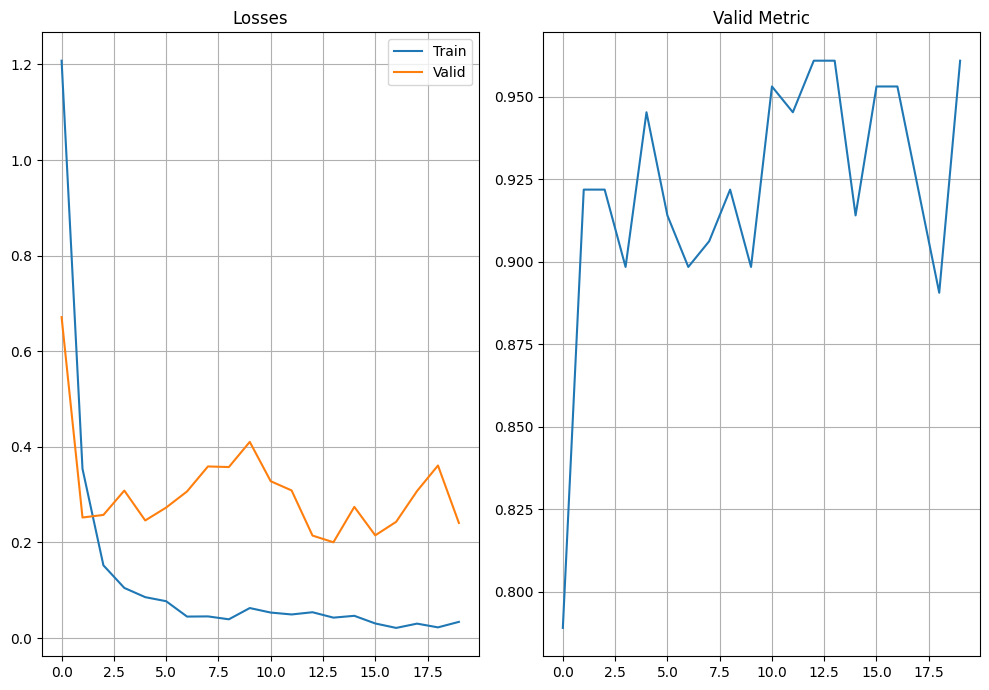

In [13]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Valid Metric')
plt.plot(range(len(valid_metrics)), valid_metrics)
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
predictions = []

model.eval()
for X in (pbar := tqdm(test_loader, desc='Test DataLoader', leave=True)):
    X = X.to(device)
    with torch.no_grad():
        output = model(X).squeeze()
        probs = torch.softmax(output, dim=-1)
        preds = torch.argmax(probs, dim=-1)
    predictions.append(preds.cpu())

predictions = np.concatenate(predictions)

Test DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
subm = pd.DataFrame({
    'id': test['id'],
    'label': le.inverse_transform(predictions)
})

subm.to_csv("submission.csv", index=False)
subm.head()

,id,label
0,P00521,knight
1,P00522,rook
2,P00523,queen
3,P00524,rook
4,P00525,bishop


In [16]:
subm['label'].value_counts()

label
knight    30
bishop    30
rook      29
queen     26
pawn      16
Name: count, dtype: int64